<a href="https://colab.research.google.com/github/Elma-dev/quantization_101/blob/main/quantizatiom_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.set_printoptions(precision=60)

<img src="https://images.contentstack.io/v3/assets/blt71da4c740e00faaa/blt40c8ab571893763a/65f370cc0c744dfa367c0793/EXX-blog-fp64-fp32-fp-16-5_(3).jpg?format=webp"/>

The cell explain difference between 64,32,16 bits representation and also show the lower precesion.
* **lower precision == fewer accurate digits we see after the decimal point**

In [ ]:
# difference between 64,32,16 bits representation
print(torch.tensor(1/3,dtype=torch.float64))
print(torch.tensor(1/3,dtype=torch.float32))
print(torch.tensor(1/3,dtype=torch.float16))

tensor(0.333333333333333314829616256247390992939472198486328125000000,
       dtype=torch.float64)
tensor(0.333333343267440795898437500000000000000000000000000000000000)
tensor(0.333251953125000000000000000000000000000000000000000000000000,
       dtype=torch.float16)


**Overflow and Underflow** refer to the issue that certain numbers excees the range that can be handled by the precesion format.
* for example we can reprensent thre number **10^6** in **32bits** but we can't in **16bits**.

In [ ]:
print(torch.tensor(10**6,dtype=torch.float32).item())
print(torch.tensor(10**6,dtype=torch.float16).item())

1000000.0
inf


To get more informations like min-val and max-val i a precesion representation  in pytorch we can use:
* **torch.finfo(torch.[type])**

In [ ]:
print(torch.finfo(torch.float32))
print(torch.finfo(torch.float16))

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)
finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)


# Symetric Quantization
In symmetric quantization, the range of the original floating-point values is mapped to a symmetric range around zero in the quantized space.
* quantized value for zero in the floating-point space is exactly zero in the quantized space.
* we take the highest absolute value (α) as the range to perform the linear mapping.
\begin{equation*}
\alpha= max(|X|)
\end{equation*}

\begin{equation*}
S=\frac{2^{b-1}-1}{\alpha}
\end{equation*}

\begin{equation*}
X_{quant}=round(S.X)
\end{equation*}

\begin{equation*}
ϵ = X - X_{quant}
\end{equation*}

\begin{equation*}
X_{dequant}=\frac{X}{S} + ϵ
\end{equation*}


In [ ]:
import torch

In [ ]:
X=torch.tensor([ 5.4700,  3.0800, -7.5900,  0.0000, -1.9500, -4.5700, 10.8000])

In [ ]:
def sym_quant_dequ(X,b):
  alpha=max(abs(X))
  S=(2**(b-1)-1)/alpha
  X_quant=torch.round(S*X)
  X_dequant=X_quant/S
  return {"x_quant":X_quant,"x_dequant":X_dequant}

In [ ]:
print(f"X befor quanti:{X}")
X_quant,X_dequant=sym_quant_dequ(X,8).values()
print(f"X after quanti:{X_quant}")
print(f"X dequantization:{X_dequant}")
error=torch.nn.functional.mse_loss(X,X_dequant)
print(f"mean error: {error}")

X befor quanti:tensor([ 5.4700,  3.0800, -7.5900,  0.0000, -1.9500, -4.5700, 10.8000])
X after quanti:tensor([ 64.,  36., -89.,   0., -23., -54., 127.])
X dequantization:tensor([ 5.4425,  3.0614, -7.5685,  0.0000, -1.9559, -4.5921, 10.8000])
mean error: 0.0002981404250022024


* **add outlier to our data will increase the error**

In [ ]:
X[-1]=1000
print(f"X befor quanti:{X}")
X_quant,X_dequant=sym_quant_dequ(X,8).values()
print(f"X after quanti:{X_quant}")
print(f"X dequantization:{X_dequant}")
error=torch.nn.functional.mse_loss(X,X_dequant)
print(f"mean error: {error}")

X befor quanti:tensor([  -8.0000,   -4.8333,   -1.6667,    0.0000,    4.6667,    7.8333,
        1000.0000])
X after quanti:tensor([ -1.,  -1.,  -0.,   0.,   1.,   1., 127.])
X dequantization:tensor([ -7.8740,  -7.8740,  -0.0000,   0.0000,   7.8740,   7.8740, 999.9999])
mean error: 3.1897339820861816


# Asymetric Quantization
Asymmetric quantization, in contrast, is not symmetric around zero. Instead, it maps the **minimum (β)** and **maximum (α)** values from the float range to the minimum and maximum values of the quantized range.

\begin{equation*}
α = max(X)  \\
β = min(X) \\
S= \frac{128--127}{α-β}\\
Z= round(-S.β) - 2^{b-1} \\
X_{quant}=round(S.X+Z)\\
X_{dequant}=\frac{X_{quant}-Z}{S}
\end{equation*}

In [ ]:
def asym_quant_dequ(X,b):
  alpha=max(X)
  beta=min(X)
  S=(2**(b-1)-(-(2**(b-1)-1)))/(alpha-beta)
  Z=torch.round(-S*beta)-(2**(b-1))
  X_quant=torch.round(S*X+Z)
  X_dequant=(X_quant-Z)/S
  return {"x_quant":X_quant,"x_dequant":X_dequant}

In [ ]:
print(f"X befor quanti:{X}")
X_quant,X_dequant=asym_quant_dequ(X,8).values()
print(f"X after quanti:{X_quant}")
print(f"X dequantization:{X_dequant}")
error=torch.nn.functional.mse_loss(X,X_dequant)
print(f"mean error: {error}")

X befor quanti:tensor([ 5.4700,  3.0800, -7.5900,  0.0000, -1.9500, -4.5700, 10.8000])
X after quanti:tensor([  53.,   20., -128.,  -23.,  -50.,  -86.,  127.])
X dequantization:tensor([ 5.4809,  3.1011, -7.5724,  0.0000, -1.9472, -4.5434, 10.8176])
mean error: 0.00027156321448273957


In [ ]:
X_out=X
X[-1]=256
print(f"X befor quanti:{X}")
X_quant,X_dequant=asym_quant_dequ(X,8).values()
print(f"X after quanti:{X_quant}")
print(f"X dequantization:{X_dequant}")
error=torch.nn.functional.mse_loss(X,X_dequant)
print(f"mean error: {error}")

X befor quanti:tensor([  5.4700,   3.0800,  -7.5900,   0.0000,  -1.9500,  -4.5700, 256.0000])
X after quanti:tensor([-116., -118., -128., -121., -123., -125.,  127.])
X dequantization:tensor([  5.1684,   3.1011,  -7.2358,   0.0000,  -2.0674,  -4.1347, 256.3542])
mean error: 0.0779305100440979


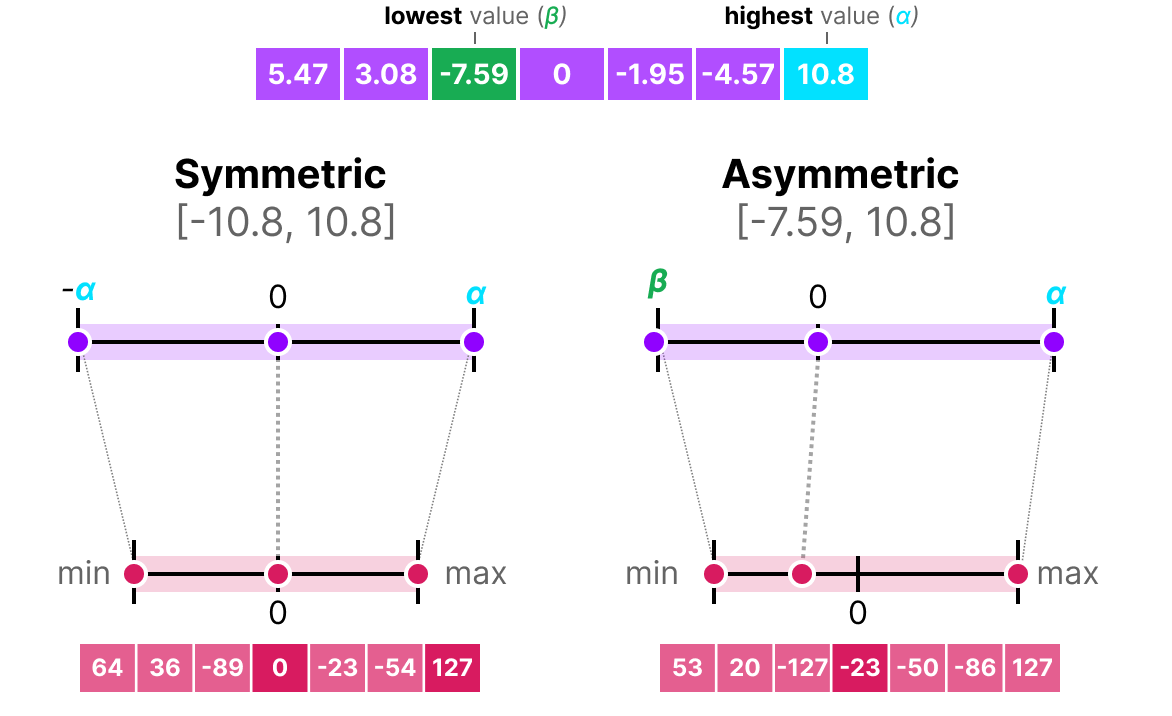

# Range Mapping and Clipping
* As We saw in tow previous methods when we add outliers the erros increased.
* when we have outlier in our data the small values would get mapped to the same lower-bit representation and lose their differentiating factor
- to solve this problem we can choose to clip certain values.
- all the outliers values will get the same value because we will use dynamic range.
- **the quatazition error** of `non outliers` is reduces, in other side the error of `outliers` will increase.
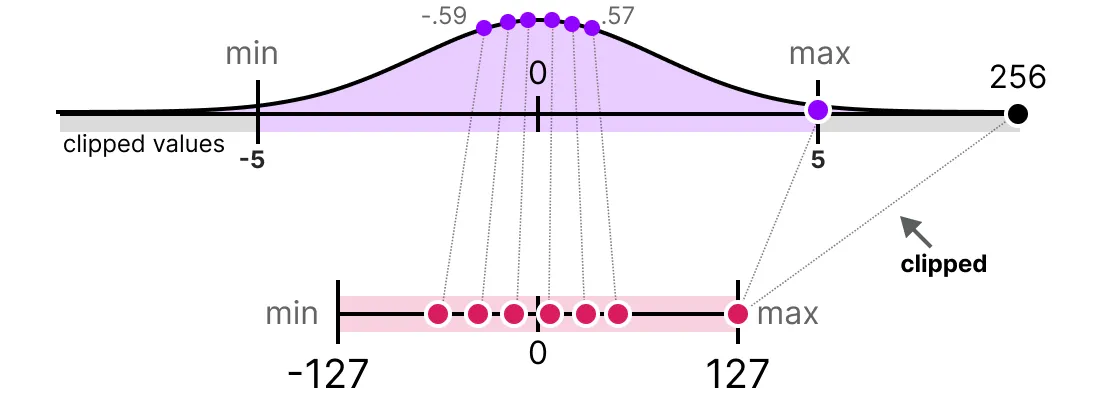

## Calibration Method
* **Calibration** is method to find range that includes as many values as possible whille minimizing the quantization error.
* after trained our model we have **weight** and **bias** as constant in this case we call it **static values**.
  * len(weighs) >> len(bias) : the bias are often kept in higher precesion like INT16.
  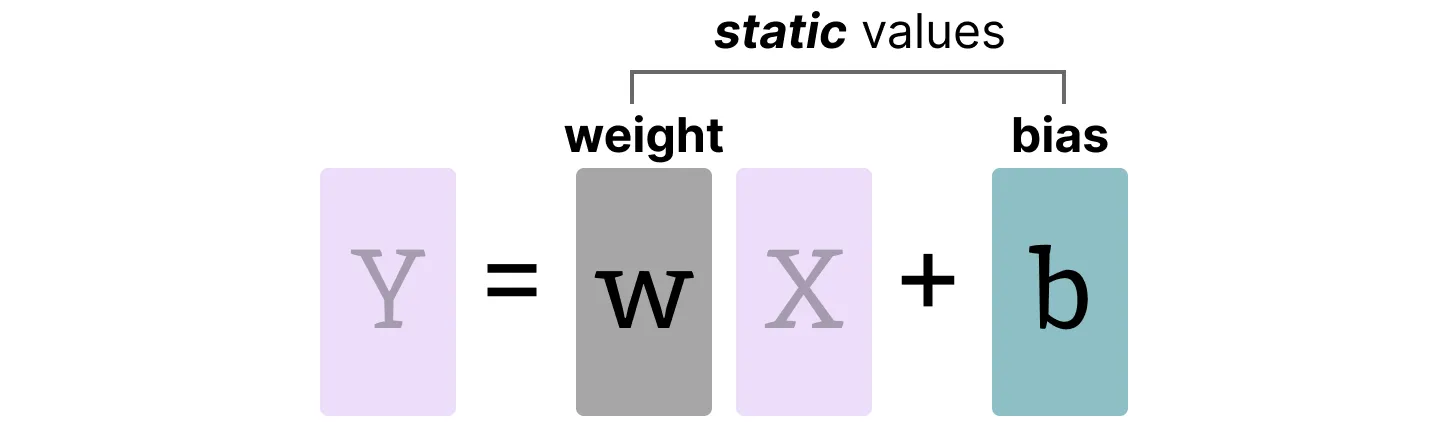
* when talk about the weights (static values) the next techs used for choosing the range:
  * Manually chosing a percentile of the input range
  \begin{equation*}
    α=percentile(X,\%)\\
    β=percentile(X,1-\%)\\
    X_{quant}[X_{quant}<(-2^{b-1})]=-2^{b-1}\\
    X_{quant}[X_{quant}>(2^{b-1}-1)]=2^{b-1}-1
  \end{equation*}
  * Optimize the mean squared error (MSE) between the original and quantized weights.
  * Minimizing entropy (KL-divergence) between the original and quantized values.

* **Dynamic Values:** after trained the neural the changeble values are `Y (output)` and `X (Input)`.
  * dynamic values makes a challenge in quantization, very hard to quantize them accurately.
  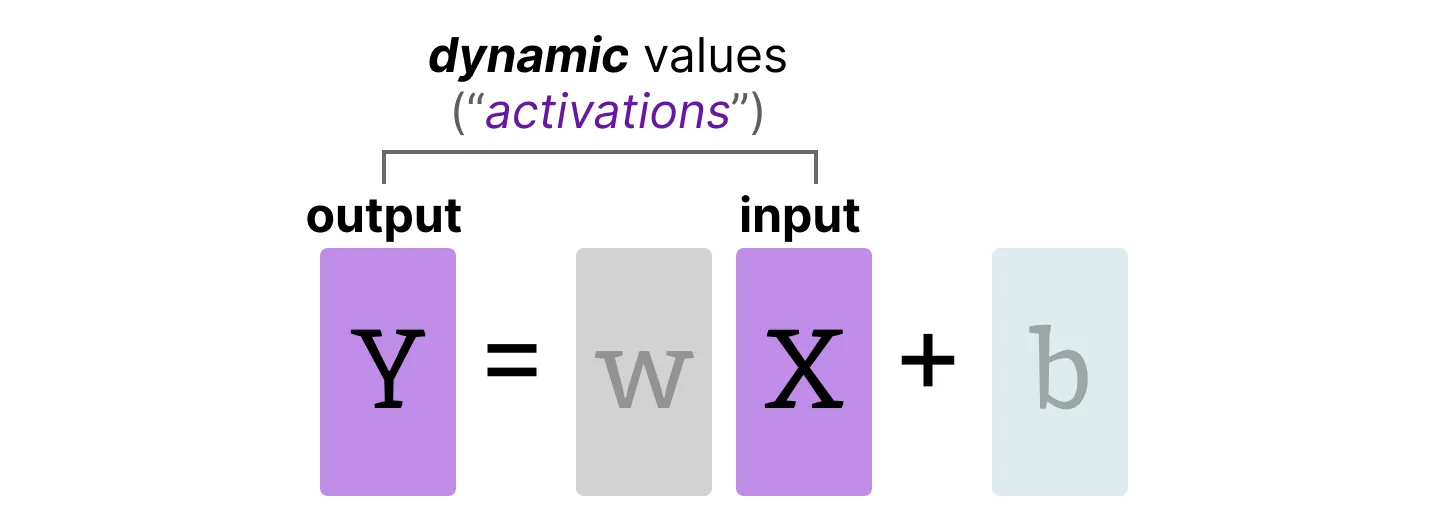

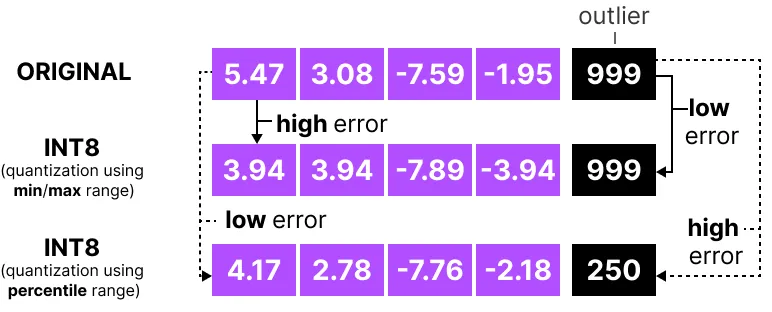

In [ ]:
def asym_percentile_quant(X,b,percent=0.5):
  alpha=torch.quantile(X,percent)
  beta=torch.quantile(X,1-percent)
  S=(2**(b-1)-(-(2**(b-1)-1)))/(alpha-beta)
  Z=torch.round(-S*beta)-(2**(b-1))
  X_quant=torch.round(S*X+Z)
  lower_bound = -2**(b-1)
  upper_bound = 2**(b-1)-1
  #X_quant[X_quant>upper_bound]=upper_bound
  #X_quant[X_quant<lower_bound]=lower_bound
  X_dequant=(X_quant-Z)/S
  return {"x_quant":X_quant,"x_dequant":X_dequant}

In [ ]:
print(f"X befor quanti:{X}")
X_quant,X_dequant=asym_percentile_quant(X,8,0.99).values()
print(f"X after quanti:{X_quant}")
print(f"X dequantization:{X_dequant}")
error=torch.nn.functional.mse_loss(X,X_dequant)
print(f"mean error: {error}")

X befor quanti:tensor([  5.4700,   3.0800,  -7.5900,   0.0000,  -1.9500,  -4.5700, 256.0000])
X after quanti:tensor([-114., -117., -128., -120., -122., -125.,  143.])
X dequantization:tensor([  5.8442,   2.9221,  -7.7922,   0.0000,  -1.9481,  -4.8701, 256.1693])
mean error: 0.0463661253452301


# Post Training Quantization (PTQ)
* Quantization After Training.
  * **Dynamic:** In dynamic quantization, only weights are quantized statically to lower precision (such as INT8), but activations are kept in higher precision (like FP32) during the inference phase.
    * Model weights are quantized to lower precision as int8 format before inference. During inference, activations are dynamically quantized, which means their scale and zero-point are computed for each batch or layer during execution.
    * Dynamic Quantization Workflow
      1. Model Training: Train your model normally.
      2. Quantization: Convert model weights to lower precision.
      3. Inference: Dynamically quantize activations during inference, allowing for adaptable performance based on input data.
  * Static
    * Static Quantization Workflow
        1. Model Training: Train your model normally.
        2. Calibration: Run the model on a representative dataset to determine quantization parameters.
        3. Quantization: Convert model weights and activations to lower precision using fixed quantization parameters.
        4. Inference: Perform fast, integer-only inference.
* Using Symetric or Asymetric Quantization Methods with Weights
* Quantization of the activations, however, requires inference of the model to get their potential distribution since we do not know their range.

**Dynamic:** we will collect the hidden layer activations outputs, and from it we will define the quantization params.
*
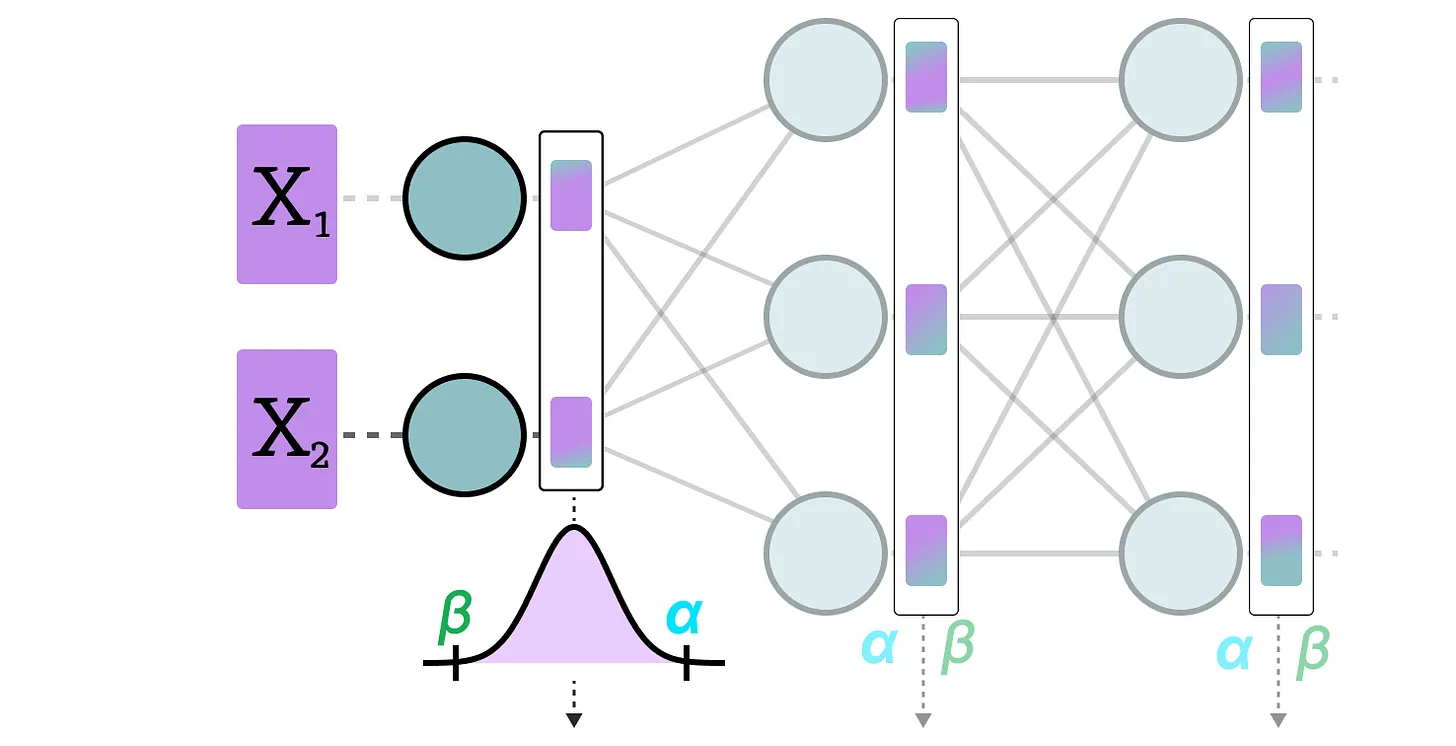
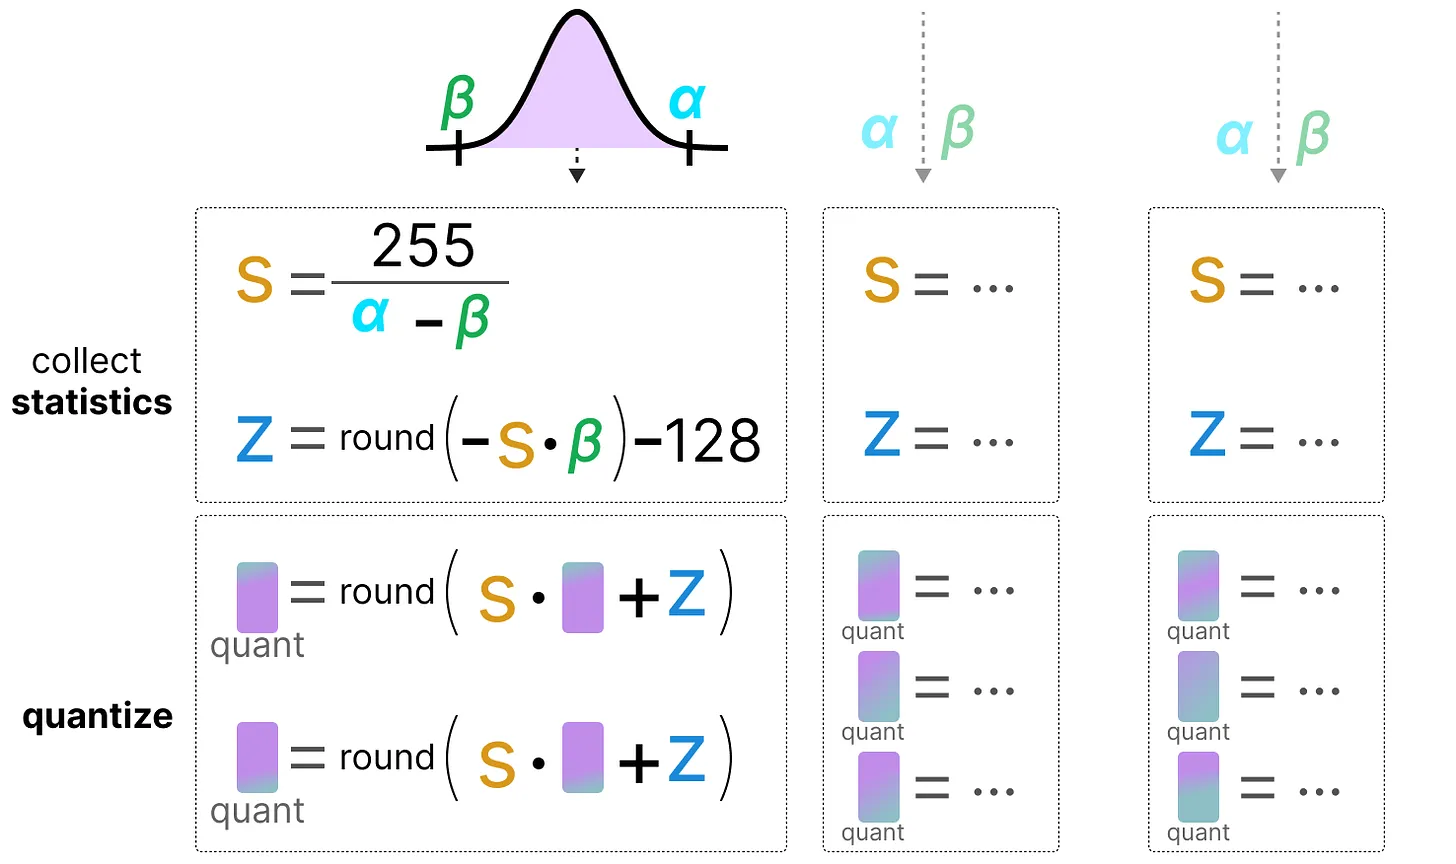

### Build/Train AlexNet With/outh Dynamic Post Training Quantization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import torch.quantization
from torch.quantization import QuantStub,DeQuantStub
from torchvision import transforms
import matplotlib.pyplot as plt
import os

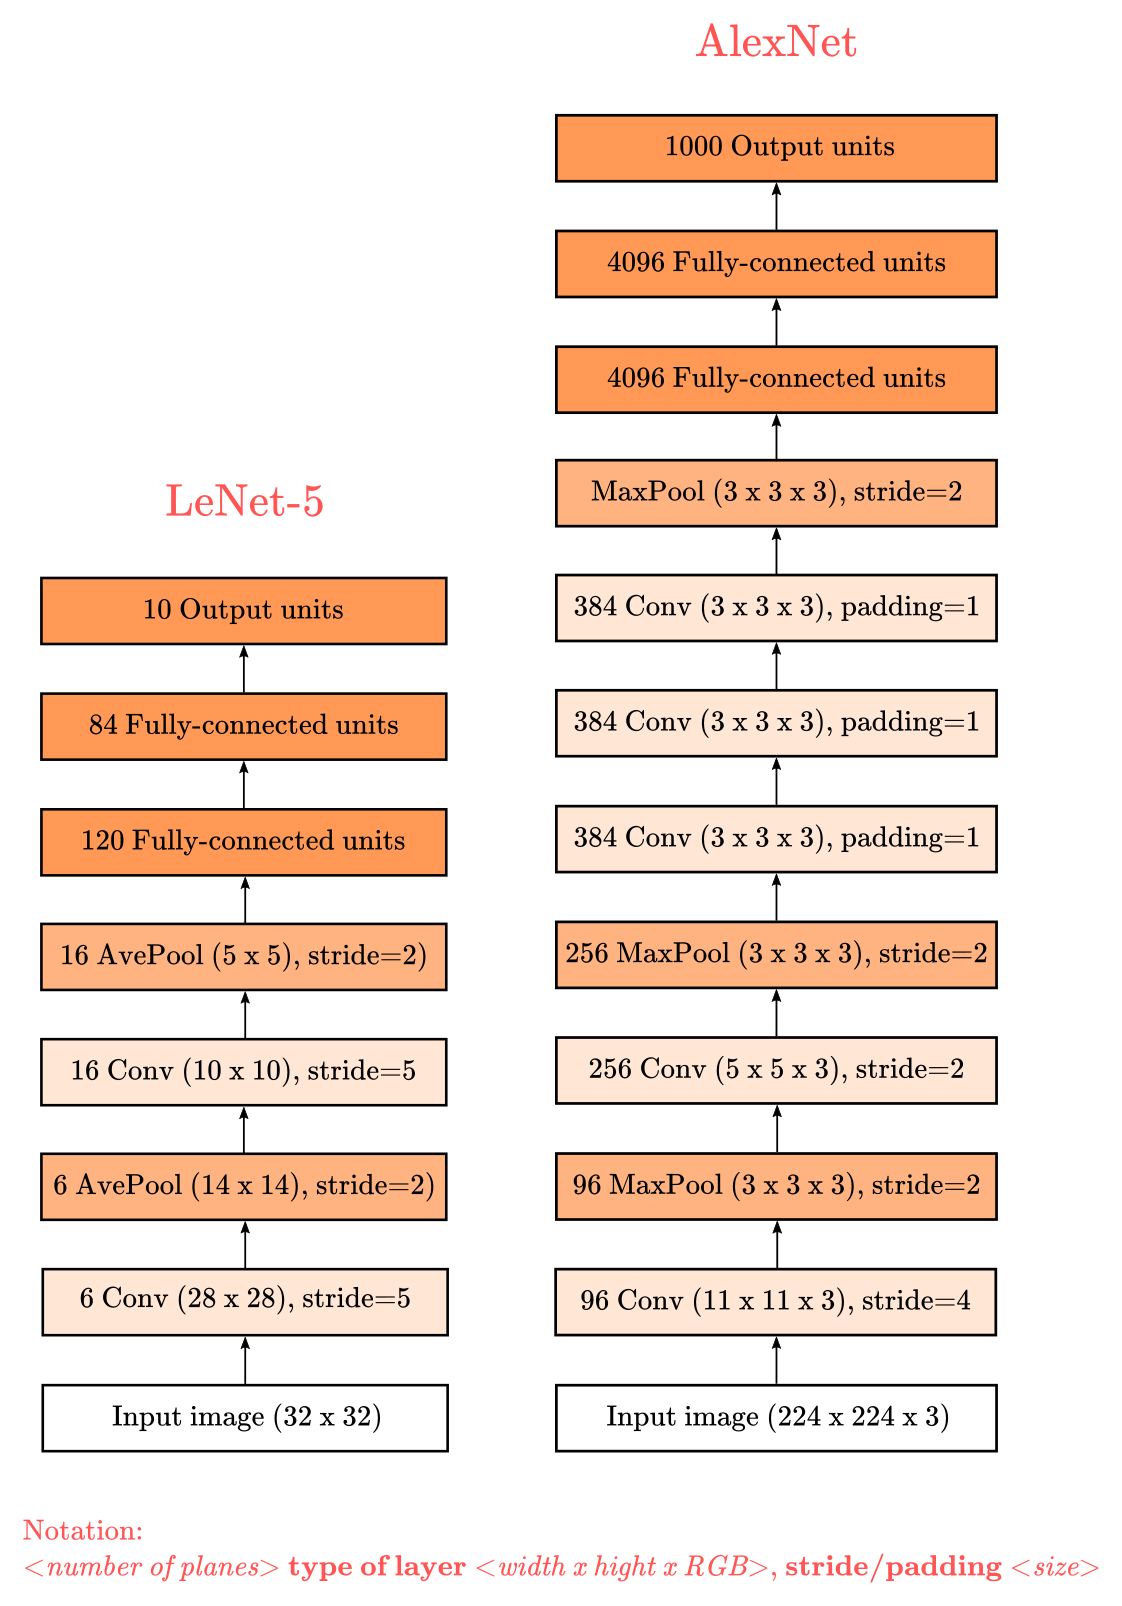

In [2]:
class ANet(nn.Module):
  def __init__(self,quant=False,num_classes=10):
    super().__init__()
    self.num_classes=num_classes
    self.conv1=nn.Sequential(
        nn.Conv2d(1,96,11,4),
        nn.ReLU(),
        nn.MaxPool2d((3,3),(2,2))
    ) # b,96*27*27
    self.conv2=nn.Sequential(
        nn.Conv2d(96,256,5,2),
        nn.ReLU(),
        nn.MaxPool2d((3,3),(2,2))
    ) #b,256x5x5
    self.conv3=nn.Sequential(
        nn.Conv2d(256,384,3,1,1),
        nn.ReLU()
    ) #b,384x3x3
    self.conv4=nn.Sequential(
        nn.Conv2d(384,384,3,1,1),
        nn.ReLU()
    ) # b,384,1,1
    self.conv5=nn.Sequential(
        nn.Conv2d(384,256,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d((3,3),(2,2)) # mtx 2 x 2 x256
    )
    self.classifier=nn.Sequential(
        nn.Dropout(p=0.5,inplace=True),
        nn.Linear(256*2*2,4096),
        nn.ReLU(),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Linear(4096,self.num_classes),
    )
    self.quant=quant
    if self.quant:
      self.quantization=QuantStub()
      self.dequantization=DeQuantStub()

  def forward(self,X):
    if self.quant:
      X=self.quantization(X)
    X=self.conv1(X)
    X=self.conv2(X)
    X=self.conv3(X)
    X=self.conv4(X)
    X=self.conv5(X)
    X=X.reshape(X.shape[0],-1)
    X=self.classifier(X)
    return self.dequantization(X) if self.quant else X

In [3]:
def train(model,train_loader,val_loader,config,device):
    model.to(device)
    cross_entropy_loss=nn.CrossEntropyLoss()
    optimizer=optim.SGD(model.parameters(),lr=config["lr"],momentum=0.9)
    for epoch in range(config["epochs"]):
      for i,(images,labels) in enumerate(train_loader):
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad() #set grad zero
        out=model(images)
        loss=cross_entropy_loss(out,labels)
        loss.backward() # calculate grad
        optimizer.step()  # update params
      print(f"epoch {epoch} loss {loss.item():.4f}")
      validation(model,val_loader,device)
def validation(model,val_loader,device):
  model.eval()
  with torch.no_grad():
    correct,total=0,0
    for images,labels in val_loader:
      images=images.to(device)
      labels=labels.to(device)
      outputs=model(images)
      _,predictions=torch.max(outputs.data,dim=1)
      total+=labels.size(0)
      correct+=(labels==predictions).sum().item()
      del images,labels,outputs
  print(f" Model Accuracy {100*correct/total}")

In [4]:
transform = transforms.Compose(
    [
      transforms.Resize((227,227)),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64,
                                         shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 898928.02it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135988.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 292244.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4608255.63it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
configs={
    "lr":0.001,
    "epochs":10
}
device="cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model=ANet(quant=False,num_classes=10)

In [ ]:
import os
torch.save(model.state_dict(),"temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)

Size (MB): 98.983402


In [ ]:
train(model,trainloader,testloader,configs,device)

epoch 0 loss 2.2952
 Model Accuracy 11.35
epoch 1 loss 0.2981
 Model Accuracy 89.2
epoch 2 loss 0.0607
 Model Accuracy 96.06
epoch 3 loss 0.0132
 Model Accuracy 98.17
epoch 4 loss 0.1296
 Model Accuracy 98.13
epoch 5 loss 0.0429
 Model Accuracy 98.54
epoch 6 loss 0.0035
 Model Accuracy 98.5
epoch 7 loss 0.0661
 Model Accuracy 98.81
epoch 8 loss 0.2183
 Model Accuracy 98.88
epoch 9 loss 0.0018
 Model Accuracy 99.01


In [9]:
sample_iter=iter(testloader)
samples,labels=next(sample_iter)

barch size: 64
image size: torch.Size([1, 227, 227])
label 7


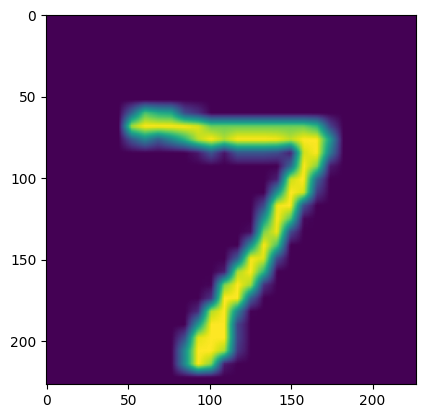

In [10]:
print(f"barch size: {len(labels)}")
print(f"image size: {samples[0].shape}")
plt.imshow(samples[0].permute(1, 2, 0))
print(f"label {labels[0]}")

In [ ]:
model.eval()
with torch.no_grad():
  print(f"model prediction: {torch.argmax(model(samples[0].reshape(1,1,227,227).to(device)),dim=-1).item()}")

model prediction: 7


**Save trained Params**

In [ ]:
torch.save(model.state_dict(),"model.p")

### Load Params

In [13]:
model.to("cpu") # model To CPU
model.load_state_dict(torch.load("drive/MyDrive/model.p",map_location=torch.device('cpu'))) # Load Params from loca into CPU

<ipython-input-13-4bc3f2ddb0f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("drive/MyDrive/model.p",map_location=torch.device('cpu'))) 

<All keys matched successfully>

In [14]:
#Evaluate The model after loading
model.eval()
with torch.no_grad():
  print(f"model prediction: {torch.argmax(model(samples[0].reshape(1,1,227,227).to(device)),dim=-1).item()}")

model prediction: 7


### Model Quantization

In [15]:
# create new Model
model_quantized=ANet(quant=True,num_classes=10)
# load params from early trained model
model_quantized.load_state_dict(model.state_dict())
# test model before quantization
validation(model_quantized,testloader,"cpu")

 Model Accuracy 99.01


In [18]:
#model size before quantization
def model_size(model,path):
  torch.save(model.state_dict(),f"{path}.p")
  print(f"size of model {os.path.getsize(f'{path}.p')/1e6}")
  os.remove(f"{path}.p")
model_size(model_quantized,"model_bq")

size of model 98.984506


In [ ]:
# initialize model quantization default configs
model_quantized.qconfig=torch.quantization.default_qconfig
# show the quantization configs
print(f"model quantized quantization configs: {model_quantized.qconfig}")
# Prepares a copy of the model for quantization calibration or quantization-aware training.
torch.quantization.prepare(model_quantized,inplace=True)
# show the layer quantization observer
print(f"after add observer: {model_quantized.conv1}")
# stat calibration by collecting some informations with test mode
validation(model_quantized,testloader,"cpu")
# apply quantization calculation
torch.quantization.convert(model_quantized,inplace=True)
# show the layer quantization observer after applying calculations
print(f"after add observer: {model_quantized.conv1}")
# size after quantization
model_size(model_quantized,"model_quantized")

model quantized quantization configs: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
after add observer: Sequential(
  (0): Conv2d(
    1, 96, kernel_size=(11, 11), stride=(4, 4)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)
 Model Accuracy 99.01
after add observer: Sequential(
  (0): QuantizedConv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), scale=0.0817684754729271, zero_point=64)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)
size of model 24.785184


In [ ]:
model_quantized

ANet(
  (conv1): Sequential(
    (0): QuantizedConv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), scale=0.0817684754729271, zero_point=64)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): QuantizedConv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), scale=0.14977365732192993, zero_point=55)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): QuantizedConv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.20624518394470215, zero_point=61, padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): QuantizedConv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.1936546415090561, zero_point=72, padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): QuantizedConv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.24079254269599915, zero_point=64, padding=(1, 1))
    (1)

after quantization we move from **98. MB to 24 MB**, and the accuracy of quantized model is:

In [ ]:
validation(model_quantized,testloader,"cpu")

 Model Accuracy 99.0


# QAT: Quantization Aware Training
* Quantization-Aware Training: In this approach, quantization is incorporated into the training process itself. The model is trained to account for the lower precision, which often leads to better accuracy compared to post-training quantization. It simulates low-precision arithmetic during training, enabling the model to adapt to the reduced precision.
<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F1ad4fa3b-b440-4be3-90bd-b66e219f191e_1368x810.png"/>

* In PTQ the we can face a problem of loss increasing mean's fall in narrow not wide minima.
<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa70ee37e-3b4f-4598-8eef-2a9ab13658c1_1200x640.png"/>
* QAT Solving the problem of narrow minima because the loss take care also in quantization erro.
<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fc3a17734-65f8-45d7-8e4e-f7bc1c592577_1824x360.png">
<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb26d3f00-f599-4c75-beb4-21d87625b1d8_1200x640.png"/>

In [7]:
qat_model=ANet(quant=True,num_classes=10)

In [8]:
qat_model.qconfig=torch.quantization.get_default_qat_qconfig("fbgemm")
torch.quantization.prepare(qat_model,inplace=True)
qat_model.conv1

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:221: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Sequential(
  (0): Conv2d(
    1, 96, kernel_size=(11, 11), stride=(4, 4)
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [11]:
train(qat_model,trainloader,testloader,configs,device)

epoch 0 loss 2.2980
 Model Accuracy 20.66
epoch 1 loss 1.2243
 Model Accuracy 79.69
epoch 2 loss 0.0349
 Model Accuracy 96.27
epoch 3 loss 0.0276
 Model Accuracy 97.39
epoch 4 loss 0.0049
 Model Accuracy 98.4
epoch 5 loss 0.2593
 Model Accuracy 98.55
epoch 6 loss 0.0443
 Model Accuracy 98.58
epoch 7 loss 0.0416
 Model Accuracy 98.74
epoch 8 loss 0.0140
 Model Accuracy 99.05
epoch 9 loss 0.0339
 Model Accuracy 98.91


In [12]:
qat_model.conv1

Sequential(
  (0): Conv2d(
    1, 96, kernel_size=(11, 11), stride=(4, 4)
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([0.0735], device='cuda:0'), zero_point=tensor([64], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-4.68222188949585, max_val=4.658592224121094)
    )
  )
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [15]:
qat_model.to("cpu")
torch.quantization.convert(qat_model.eval(),inplace=True)

ANet(
  (conv1): Sequential(
    (0): QuantizedConv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), scale=0.07354971766471863, zero_point=64)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): QuantizedConv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), scale=0.1479116678237915, zero_point=56)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): QuantizedConv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.13613131642341614, zero_point=46, padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): QuantizedConv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), scale=0.16165225207805634, zero_point=66, padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): QuantizedConv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.17288635671138763, zero_point=62, padding=(1, 1))
    (1

In [18]:
model_size(qat_model,"qat_model")

size of model 24.94238


# Mixed-Precision:
* mixed: because we switch between 32 and 16 bits during training.

1. converting weights form 32bits to lower precesion 16bit for faster computation.
2. calculate gradient with FP16
3. back to FP32 (casting FP32(FP16))  
4. update the orinale weights.

**Init (FP32) --> (FP16) --> Forward (16FP) --> Backward (16FP) --> (FP32) --> UpdateParams**
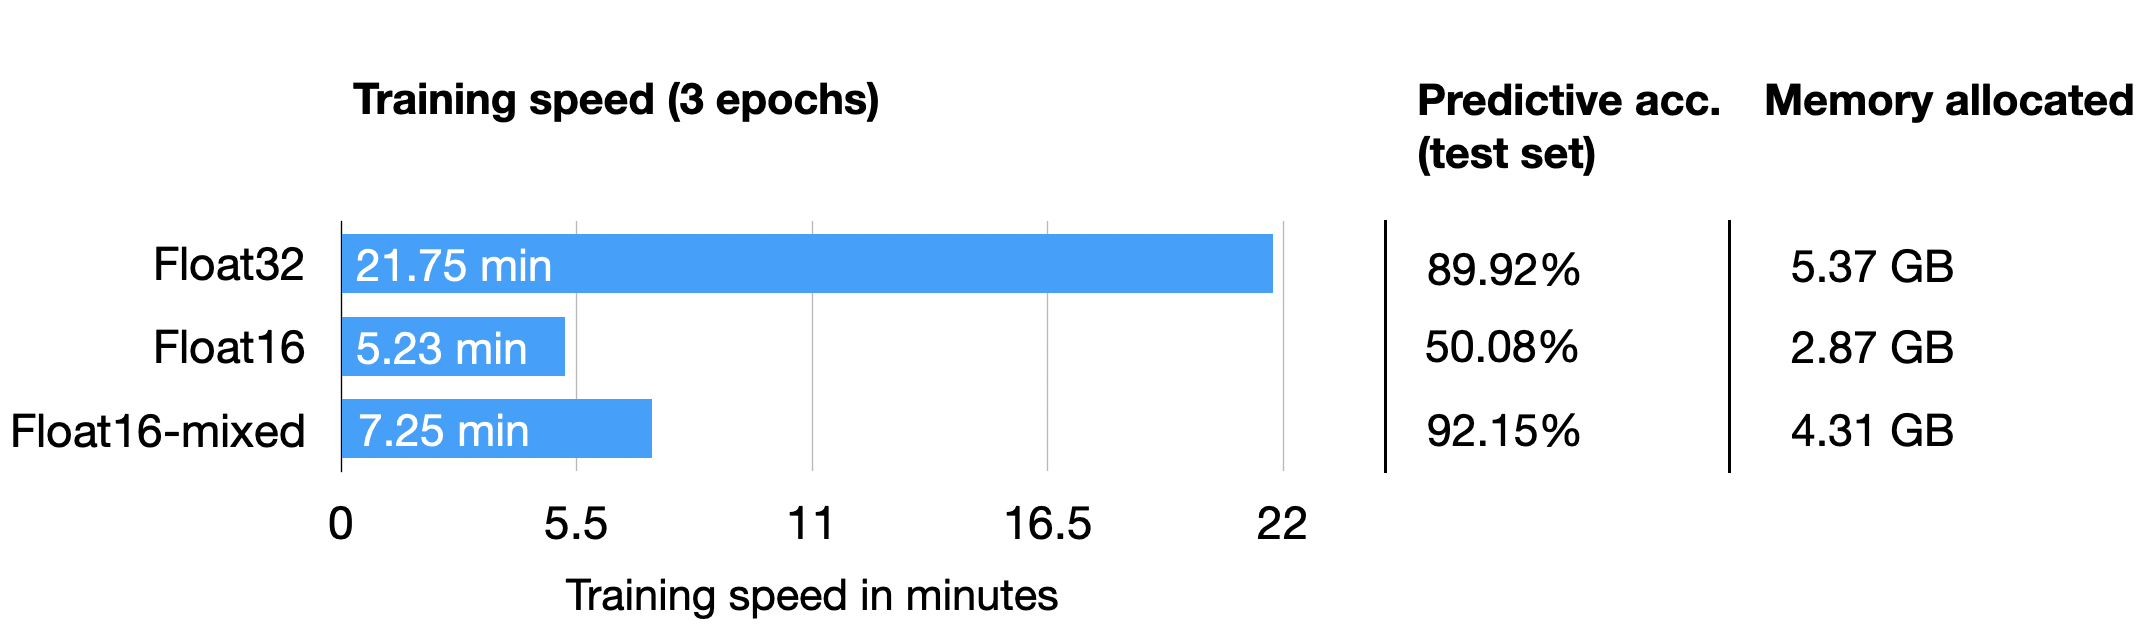

* **Bfloat** (Brain Floating point)  developed by google for their TPUs.
* Bfloat16 extends the dynamic range compared to the conventional float 16 format as the expense of decrease precesion.

![image.png]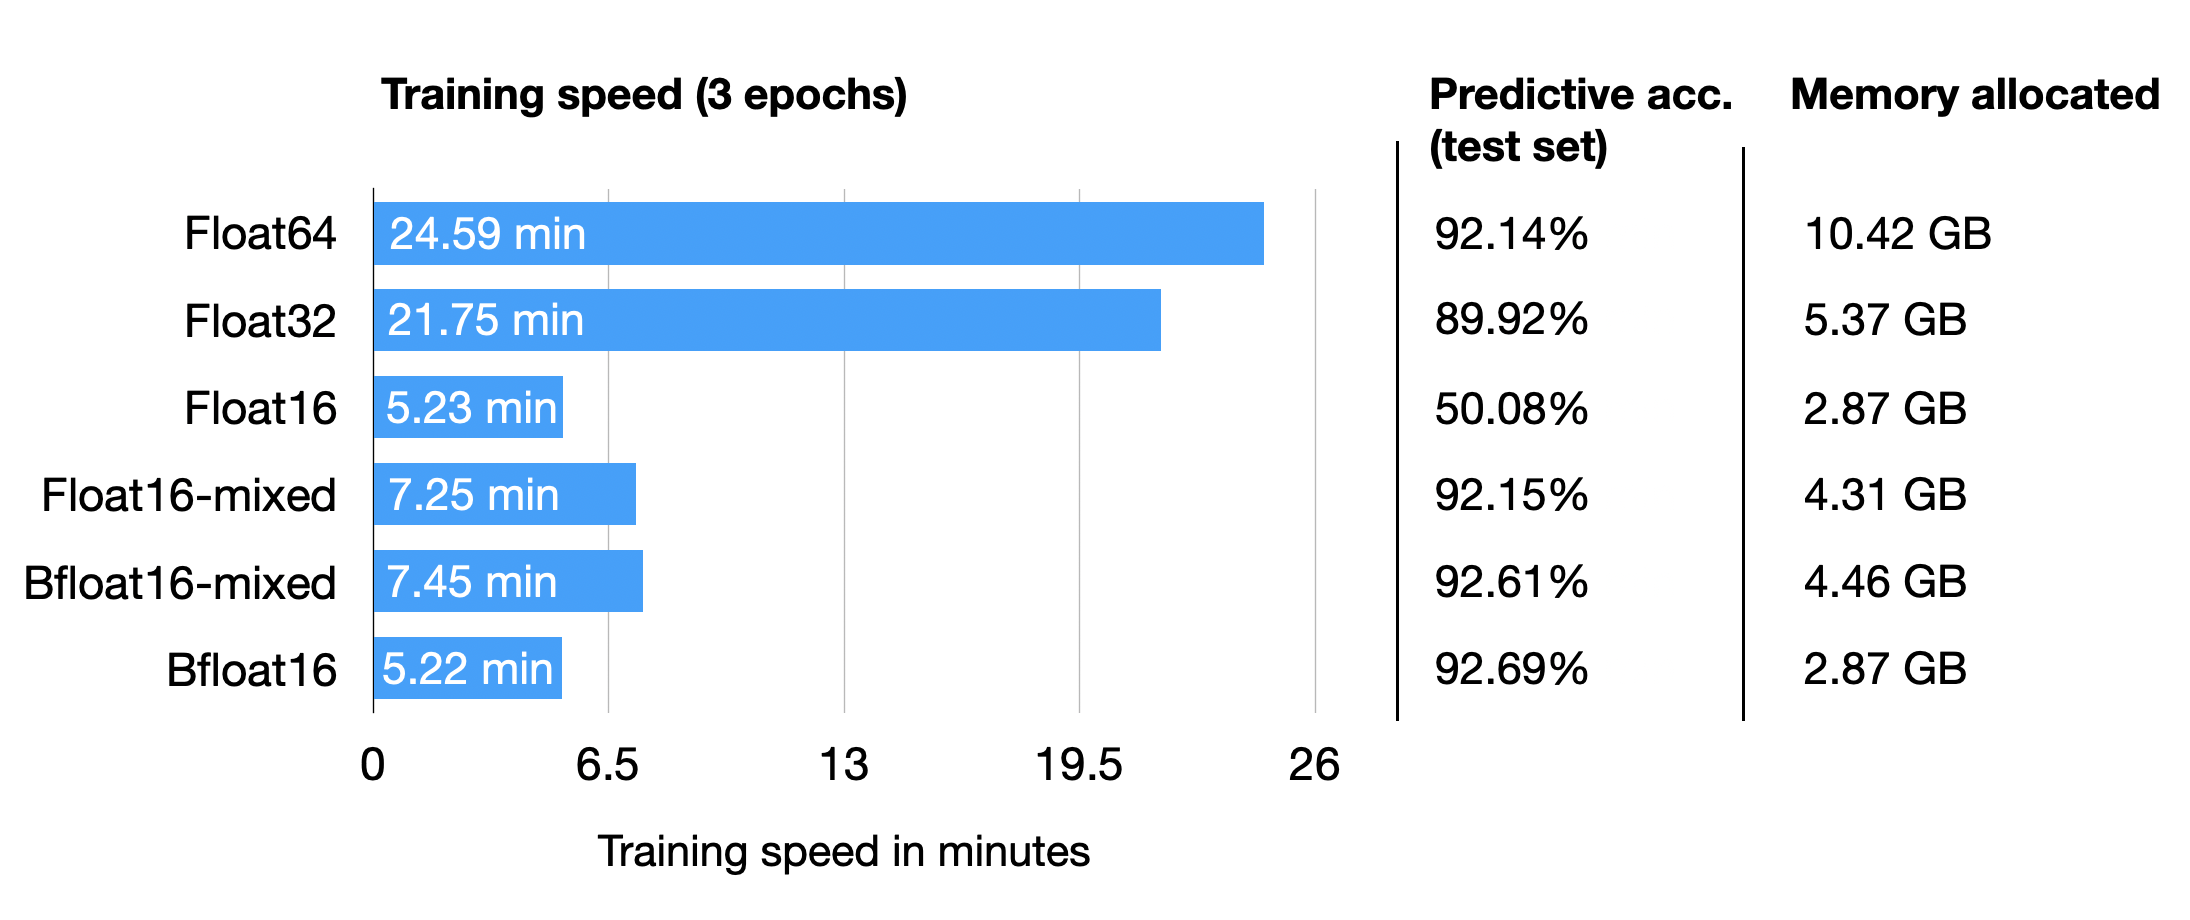

In [ ]:
# supported also by n-gpu check
'''torch.cuda.is_bf16_supported()'''

'torch.cuda.is_bf16_supported()'